In [1]:
# Importando dependências
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import numpy as np
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
# função para impressão da avaliação dos modelos
def result(dado1, dado2):
    print('____________________________________')
    print('')
    print('      Resultado das Regressões      ')
    print('')
    print('Linear:                        {:.2f}%'.format(dado1))
    print('Árvore de Decisão:             {:.2f}%'.format(dado2))
    print('____________________________________')

In [3]:
# importando dataset Avocados Price
dado = pd.read_csv('avocado.csv', parse_dates=True)

In [4]:
# retirando coluna desnecessária
dado.drop(columns='Unnamed: 0', inplace=True)
dado.drop(columns='year', inplace=True)

In [5]:
# traduzindo colunas
traducao = {'Date': 'Data', 'AveragePrice': 'Preço Médio', 'Total Volume': 'Volume Total',
            '4046': 'Pequeno', '4225': 'Medio', '4770': 'Grande', 'Total Bags': 'Total Sacos',
            'Small Bags': 'Sacos Pequenos', 'Large Bags': 'Sacos Grandes',  'XLarge Bags': 'Sacos Extra-Grandes',
             'type': 'Tipo', 'year': 'Ano', 'region': 'Região'}
dado.rename(columns=(traducao), inplace=True)

dia_traducao = {'Friday': 'Sexta', 'Monday':'Segunda', 'Saturday': 'Sábado', 'Sunday':'Domingo', 'Thursday': 'Quinta', 
                'Tuesday': 'Terça', 'Wednesday': 'Quarta'}
dado.replace(dia_traducao, inplace=True)

In [6]:
# # formatando colunas Data, colocando data em ordem e  setando index
dado['Data'] = pd.to_datetime(dado['Data'])
dado['Ano'] = pd.to_numeric(dado.Data.dt.strftime('%Y'))
dado['Mês'] = pd.to_numeric(dado.Data.dt.strftime('%m'))
dado['Dia'] = pd.to_numeric(dado.Data.dt.strftime('%d'))
dado = dado.sort_values(by='Data')
dado = dado.set_index('Data')

In [7]:
# formato dos dados
dado.dtypes

Preço Médio            float64
Volume Total           float64
Pequeno                float64
Medio                  float64
Grande                 float64
Total Sacos            float64
Sacos Pequenos         float64
Sacos Grandes          float64
Sacos Extra-Grandes    float64
Tipo                    object
Região                  object
Ano                      int64
Mês                      int64
Dia                      int64
dtype: object

In [8]:
# formato da tabela
dado.shape

(18249, 14)

In [9]:
# Visualizando dataset
dado

,Preço Médio,Volume Total,Pequeno,Medio,Grande,Total Sacos,Sacos Pequenos,Sacos Grandes,Sacos Extra-Grandes,Tipo,Região,Ano,Mês,Dia
Data,,,,,,,,,,,,,,
2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.00,organic,Southeast,2015,1,4
2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.00,organic,Chicago,2015,1,4
2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.00,organic,HarrisburgScranton,2015,1,4
2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.00,conventional,Pittsburgh,2015,1,4
2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.00,organic,Boise,2015,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-25,1.36,908202.13,142681.06,463136.28,174975.75,127409.04,103579.41,22467.04,1362.59,conventional,Chicago,2018,3,25
2018-03-25,0.70,9010588.32,3999735.71,966589.50,30130.82,4014132.29,3398569.92,546409.74,69152.63,conventional,SouthCentral,2018,3,25
2018-03-25,1.42,163496.70,29253.30,5080.04,0.00,129163.36,109052.26,20111.10,0.00,organic,SouthCentral,2018,3,25


In [13]:
# dados nulos
dado.isna().sum()

Preço Médio            0
Volume Total           0
Pequeno                0
Medio                  0
Grande                 0
Total Sacos            0
Sacos Pequenos         0
Sacos Grandes          0
Sacos Extra-Grandes    0
Tipo                   0
Região                 0
Ano                    0
Mês                    0
Dia                    0
dtype: int64

In [14]:
# dados duplicados
dado.duplicated().sum()
dado.drop_duplicates(inplace=True)

In [15]:
# Número de valores únicos para os dados categóricos
dado.select_dtypes(include='object').nunique()

Tipo       2
Região    54
dtype: int64

In [16]:
# Agrupando dados pela média dos preços por dia
preço_dia = dado.groupby('Data')[['Preço Médio','Ano','Mês', 'Dia']].mean()

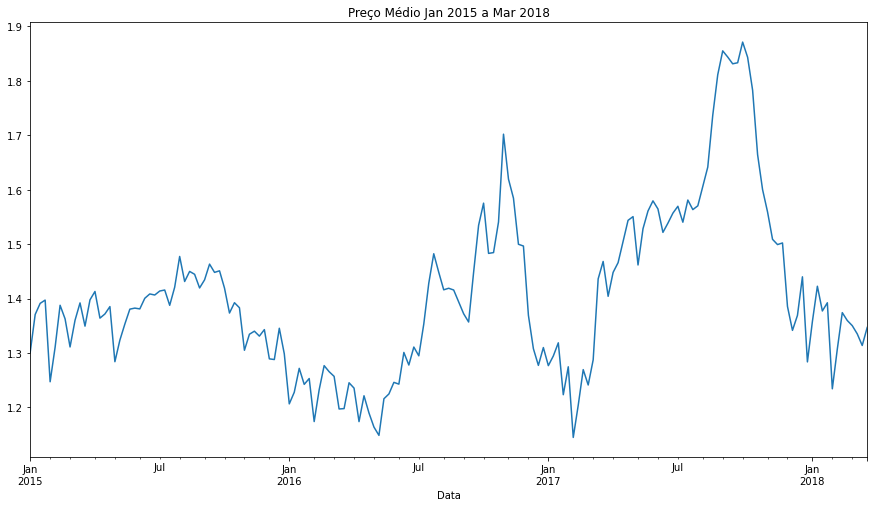

In [17]:
# Plotando variável
ax = preço_dia['Preço Médio'].plot()
ax.set_title('Preço Médio Jan 2015 a Mar 2018')
plt.gcf().set_size_inches(15, 8)

In [19]:
# nova instância
preço = preço_dia

In [20]:
# Agrupando dados pela média dos preços por dia
preço_dia = dado.groupby('Data')[['Preço Médio','Ano','Mês', 'Dia']].mean()

In [21]:
# FEATURE ENGINEERING:
# COMPONENTE AUTOREGRESSIVO: extraindo informações da variável alvo que
# sirva de informações explanatórias:
preço['p_l1'] = preço['Preço Médio'].shift(1)
preço['p_l2'] = preço['Preço Médio'].shift(2)
preço['p_l3'] = preço['Preço Médio'].shift(3)
preço['p_l4'] = preço['Preço Médio'].shift(4)
preço['p_l5'] = preço['Preço Médio'].shift(5)

In [22]:
# Retirando dados nulos
preço = preço.dropna()

In [19]:
# Criando X e y
X = preço.drop(columns='Preço Médio')
y = preço['Preço Médio']

# Criando Train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.25,
                                                   random_state=42, shuffle=False)

In [20]:
# Fit Regressão Linear
ln = LinearRegression()
ln.fit(X_train, y_train)

LinearRegression()

In [21]:
# Treino e Teste REGRESSÃO LINEAR
train_fcst = ln.predict(X_train)
test_fcst = ln.predict(X_test)

In [22]:
# R2 mede a qualidade do modelo de 0 a 1, quanto mais próximo deste melhor a qualidade do modelo
train_r2 = r2_score(y_train, train_fcst)
test_r2 = r2_score(y_test, test_fcst)

print('Pontuação Treino {:.2f}%\nPontuação Teste {:.2f}%'.format(train_r2, test_r2))
resultado1 = test_r2

Pontuação Treino 0.83%
Pontuação Teste 0.89%


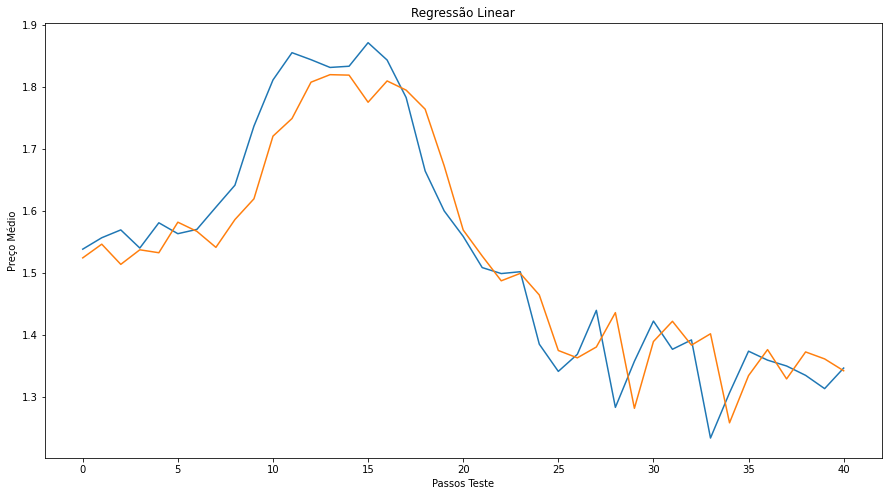

In [23]:
# Plotando Dados Reais e Dados Previstos
plt.plot(list(y_test)) # AZUL: preço médio
plt.plot(list(test_fcst)) # LARANJA: preço médio previsto
plt.title('Regressão Linear')
plt.xlabel('Passos Teste')
plt.ylabel('Preço Médio')
plt.gcf().set_size_inches(15, 8)

In [24]:
# Fit Árvore de Decisão
my_dt = DecisionTreeRegressor(random_state=12345)
my_dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=12345)

In [25]:
# GridSearchCV para buscar os melhores hiperparâmetros para regressão
my_dt = GridSearchCV(DecisionTreeRegressor(random_state=44),
                     {'min_samples_split': list(range(20,50, 2)),
                      'max_features': [0.6, 0.7, 0.8, 0.9, 1.],
                      'criterion': ['mse', 'absolute_error']},
                     scoring = 'r2', n_jobs = -1)
my_dt.fit(X_train, y_train)
resultado2 = r2_score(list(y_test), list(my_dt.predict(X_test)))
print("Resultado de avaliação do modelo com os melhores hiperparâmetros: {:.2f}%".format(resultado2))

Resultado de avaliação do modelo com os melhores hiperparâmetros: 0.45%


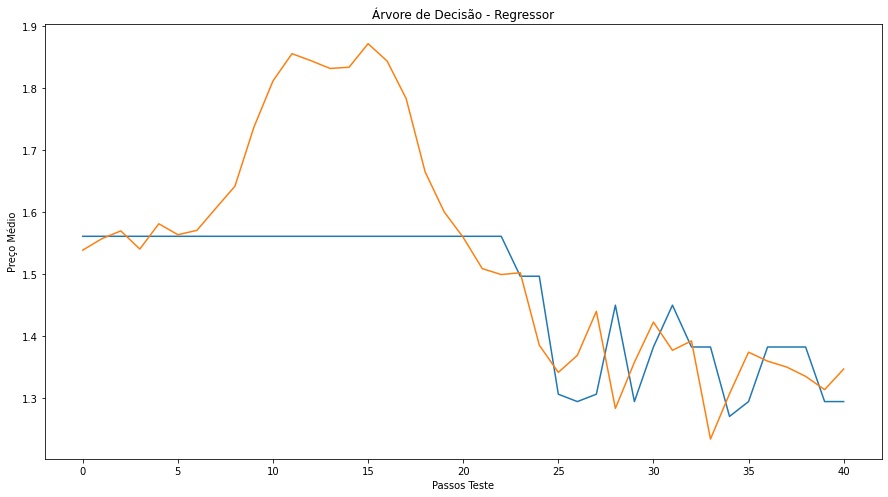

In [26]:
# Plotando o resultado da Árvore de Decisão
fcst = my_dt.predict(X_test)
plt.plot(list(fcst))
plt.plot(list(y_test))
plt.title('Árvore de Decisão - Regressor')
plt.xlabel('Passos Teste')
plt.ylabel('Preço Médio')
plt.gcf().set_size_inches(15, 8)

In [27]:
result(resultado1, resultado2)

____________________________________

      Resultado das Regressões      

Linear:                        0.89%
Árvore de Decisão:             0.45%
____________________________________
